# Import Packages 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# colab 
from google.colab import drive 

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Training data 



## Train variants 

In [2]:
train_variants = pd.read_csv("/home/fshokor/Desktop/Uni/Kaggle/data/msk-redefining-cancer-treatment/training_variants")
print('Number of data points : ', train_variants.shape[0])
print('Number of features : ', train_variants.shape[1])
print('Features : ', train_variants.columns.values)
train_variants.head()


Number of data points :  3321
Number of features :  4
Features :  ['ID' 'Gene' 'Variation' 'Class']


,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


training_variants is a comma separated file containing the description of the genetic mutations used for training.
* ID : the id of the row used to link the mutation to the clinical evidence
* Gene : the gene where this genetic mutation is located
* Variation : the aminoacid change for this mutations
* Class : 1-9 the class this genetic mutation has been classified on

In [3]:
# Count of Unique Values of Gene
train_variants["Gene"].value_counts()

BRCA1     264
TP53      163
EGFR      141
PTEN      126
BRCA2     125
         ... 
RYBP        1
MDM2        1
CTLA4       1
ARID1A      1
FAM58A      1
Name: Gene, Length: 264, dtype: int64

We have 264 different genes

In [4]:
# Count of Unique Values of Variation
train_variants["Variation"].value_counts()

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
                        ..
H1094R                   1
M1250T                   1
PTPRZ1-MET Fusion        1
H1106D                   1
K83E                     1
Name: Variation, Length: 2996, dtype: int64

We have 2996 variation 

In [5]:
#checking number of unique values for 'Gene+Variation' combinations
G_V = train_variants.copy()
G_V['gene_and_variation']=train_variants['Gene']+' '+train_variants['Variation']
G_V.head()
G_V['gene_and_variation'].value_counts()

FAM58A Truncating Mutations    1
PTEN C124R                     1
PTEN A126S                     1
PTEN R130G                     1
PTEN H93Q                      1
                              ..
FANCA Truncating Mutations     1
FANCA H492R                    1
FANCA Y510C                    1
FANCA Deletion                 1
RUNX1 K83E                     1
Name: gene_and_variation, Length: 3321, dtype: int64

All combinations 'Gene + Variation' in these datasets are unique

In [6]:
train_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

 It's a Multi class classification problem

In [7]:
# detect missing values 
train_variants.isnull().sum()

ID           0
Gene         0
Variation    0
Class        0
dtype: int64

There is no missing data  

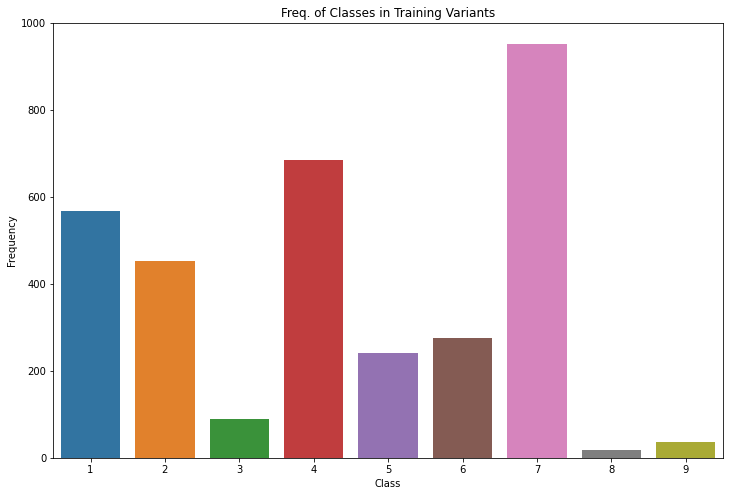

In [8]:
# plot Distribution of class
# colab 
plt.figure(figsize=(12,8))
ax = sns.countplot(x="Class", data=train_variants)
plt.ylabel('Frequency'); plt.xlabel('Class')
plt.title('Freq. of Classes in Training Variants')
plt.show()

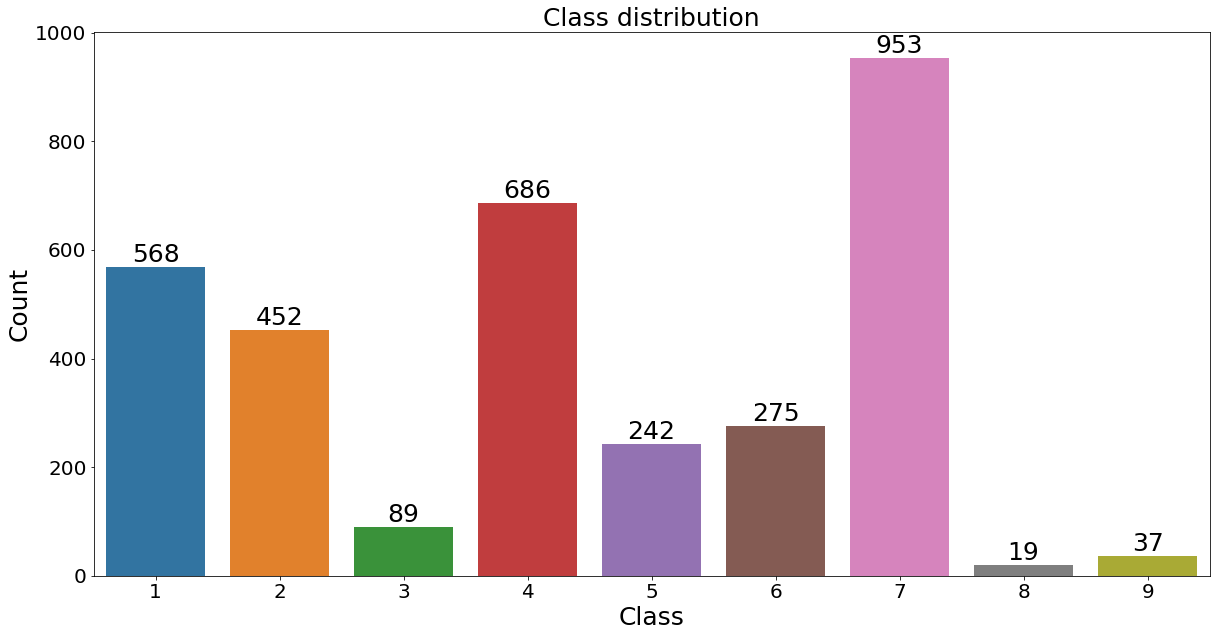

In [9]:
# plot Distribution of class
# jupyter 
plt.figure(figsize=(20,10))
g = sns.countplot(x = train_variants["Class"])
plt.title("Class distribution", fontsize = 25)
g.bar_label(g.containers[0], fontsize = 25)

plt.xlabel("Class",fontsize = 25)
plt.ylabel("Count",fontsize = 25)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)

plt.show()

Classes seem very imbalanced

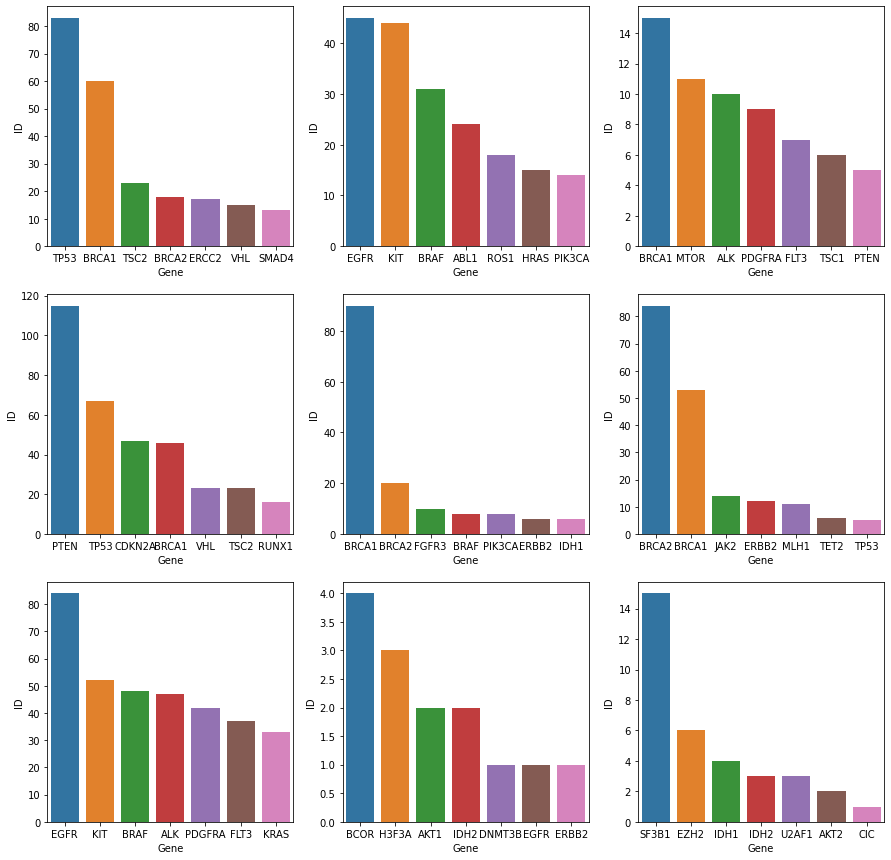

In [10]:
# Genes that has highest number of occurrences in each class
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = train_variants[train_variants["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])



Some points we can conclude from these graphs:

* BRCA1 is highly dominating Class 5
* SF3B1 is highly dominating Class 9
* BRCA1 and BRCA2 are dominating Class 6



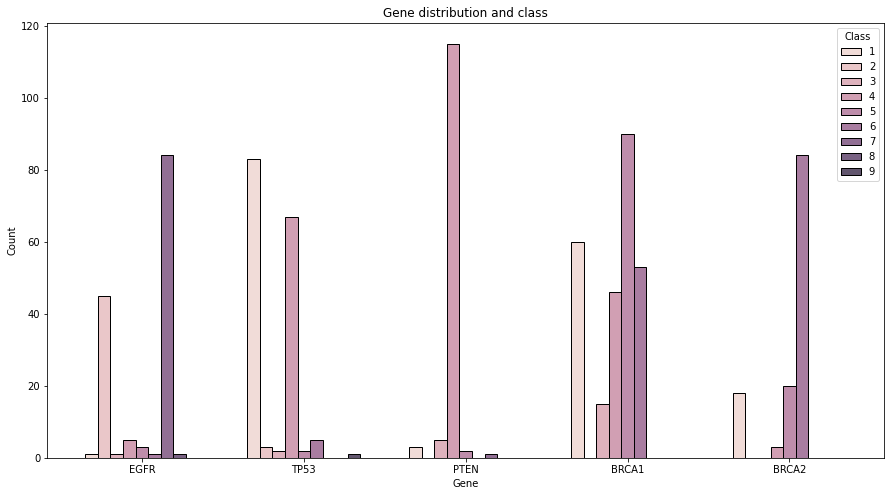

In [11]:
# Distribution of 5 most common genes 
gene_count = train_variants["Gene"].value_counts().loc[lambda x : x > 100].to_dict()
plt.figure(figsize=(15,8))
sns.histplot(data=train_variants[train_variants["Gene"].isin(gene_count.keys())],
             x="Gene", hue="Class", multiple="dodge", shrink=.7)
plt.title("Gene distribution and class")
plt.show()

A relation between gene and class could be present 

## Train text

In [13]:
train_text = pd.read_csv("/home/fshokor/Desktop/Uni/Kaggle/data/msk-redefining-cancer-treatment/training_text",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print('Number of data points : ', train_text.shape[0])
print('Number of features : ', train_text.shape[1])
print('Features : ', train_text.columns.values)
train_text.head()

Number of data points :  3321
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [14]:
train_text.Text.nunique()

1920

train_text is double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. 
* ID (the id of the row used to link the clinical evidence to the genetic mutation)
* Text (the clinical evidence used to classify the genetic mutation)

We have 1920 different text for 3321 raw (ID)

In [15]:
count_text = train_text.copy()
count_text .loc[:, 'Text_count']  = count_text ["Text"].apply(lambda x: len( str(x).split()))
count_text .head()


,ID,Text,Text_count
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,Abstract Background Non-small cell lung canc...,5756
2,2,Abstract Background Non-small cell lung canc...,5756
3,3,Recent evidence has demonstrated that acquired...,5572
4,4,Oncogenic mutations in the monomeric Casitas B...,6202


## Merge Data 

In [19]:
df_merge = pd.merge(train_variants,count_text, on="ID",how="left")
df_merge.head()

,ID,Gene,Variation,Class,Text,Text_count
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...,6089
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...,5756
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...,5756
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...,5572
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...,6202


There are multiple rows with similar texts

In [20]:
count_grp = df_merge.groupby('Class')["Text_count"]
count_grp.describe()

,count,mean,std,min,25%,50%,75%,max
Class,,,,,,,,
1,568.0,9450.299296,6516.412101,1.0,4973.0,7305.0,12873.5,52972.0
2,452.0,9310.393805,7627.288722,116.0,4185.0,6810.0,12220.0,61957.0
3,89.0,6757.382022,3725.366918,1737.0,4283.0,5572.0,7415.0,27391.0
4,686.0,8983.390671,7280.220754,53.0,4566.0,6351.0,11537.0,43913.0
5,242.0,7517.049587,3902.868040,183.0,5245.0,6463.0,9513.5,24226.0
6,275.0,7184.120000,3836.912865,1.0,4505.5,6587.0,7847.0,24609.0
7,953.0,11442.867786,10111.940846,1.0,4871.0,8254.0,14620.0,76782.0
8,19.0,10814.421053,5648.714095,2111.0,5586.0,11253.0,15535.0,20626.0
9,37.0,12807.459459,10217.093429,1147.0,4942.0,10930.0,15797.0,45177.0


In [21]:
df_merge[df_merge["Text_count"]==1.0]

,ID,Gene,Variation,Class,Text,Text_count
1109,1109,FANCA,S1088F,1,NaN,1
1277,1277,ARID5B,Truncating Mutations,1,NaN,1
1407,1407,FGFR3,K508M,6,NaN,1
1639,1639,FLT1,Amplification,6,NaN,1
2755,2755,BRAF,G596C,7,NaN,1


we can see there are some entries without any text data

/home/fshokor/miniconda3/envs/RAPMC/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fshokor/miniconda3/envs/RAPMC/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 53.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fshokor/miniconda3/envs/RAPMC/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fshokor/miniconda3/envs/RAPMC/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/fshokor/minico

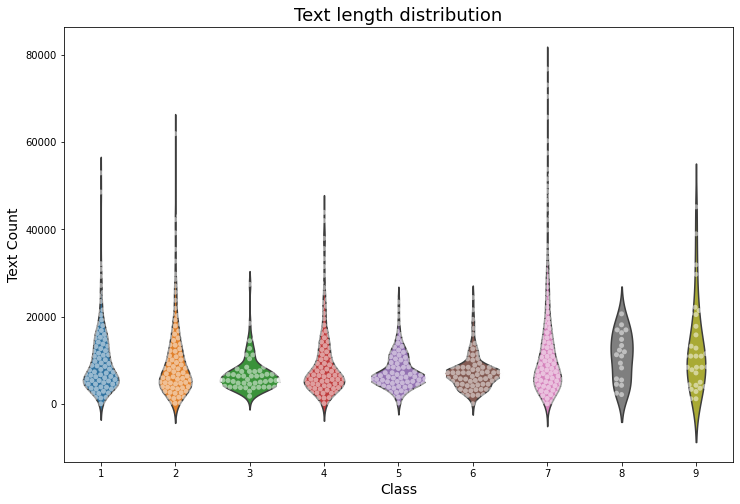

In [22]:
# Get distribution of text count for each class
plt.figure(figsize=(12,8))
gene_count_grp = df_merge.groupby('Gene')["Text_count"].sum().reset_index()
sns.violinplot(x="Class", y="Text_count", data=df_merge, inner=None)
sns.swarmplot(x="Class", y="Text_count", data=df_merge, color="w", alpha=.5);
plt.ylabel('Text Count', fontsize=14)
plt.xlabel('Class', fontsize=14)
plt.title("Text length distribution", fontsize=18)
plt.show()

All classes have most counts in between 0 to 20000

# Test data 



## Test variants 

In [23]:
test_variants = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/test_variants")
print('Number of data points : ', test_variants.shape[0])
print('Number of features : ', test_variants.shape[1])
print('Features : ', test_variants.columns.values)
test_variants.head()


Number of data points :  5668
Number of features :  3
Features :  ['ID' 'Gene' 'Variation']


,ID,Gene,Variation
0,0,ACSL4,R570S
1,1,NAGLU,P521L
2,2,PAH,L333F
3,3,ING1,A148D
4,4,TMEM216,G77A


test_variants is a comma separated file containing the description of the genetic mutations used for training.
* ID : the id of the row used to link the mutation to the clinical evidence
* Gene : the gene where this genetic mutation is located
* Variation : the aminoacid change for this mutations


In [16]:
# Count of Unique Values of Gene
test_variants["Gene"].value_counts()

F8       134
CFTR      57
F9        54
G6PD      46
GBA       39
        ... 
MYC        1
NODAL      1
TUBB1      1
REEP1      1
ELF3       1
Name: Gene, Length: 1397, dtype: int64

We have 1397 different genes

In [17]:
# Count of Unique Values of Variation
test_variants["Variation"].value_counts()

Truncating Mutations    18
Deletion                14
Amplification            8
Fusions                  3
G44D                     2
                        ..
T196I                    1
R182L                    1
R674H                    1
H23Y                     1
T185M                    1
Name: Variation, Length: 5628, dtype: int64

We have 5628 variation 

In [18]:
#checking number of unique values for 'Gene+Variation' combinations
G_V_test = test_variants.copy()
G_V_test['gene_and_variation']=test_variants['Gene']+' '+test_variants['Variation']
G_V_test.head()
G_V_test['gene_and_variation'].value_counts()

MLC1 N141K        1
PLA2G7 I198T      1
MYO7A R244P       1
G6PD C415R        1
HMBS G216D        1
                 ..
NOTCH3 R182C      1
ATP6V0A4 M580T    1
SCN4A I141V       1
PAH R408W         1
KRT9 L160V        1
Name: gene_and_variation, Length: 5668, dtype: int64

All combinations 'Gene + Variation' in these datasets are unique

In [19]:
# detect missing values 
test_variants.isnull().sum()

ID           0
Gene         0
Variation    0
dtype: int64

There is no missing data  

## Test text

In [20]:
test_text = pd.read_csv("/content/gdrive/MyDrive/Kaggle/msk-redefining-cancer-treatment/test_text",sep="\|\|", engine="python", skiprows=1, names=["ID", "Text"])
print('Number of data points : ', test_text.shape[0])
print('Number of features : ', test_text.shape[1])
print('Features : ', test_text.columns.values)
test_text.head()

Number of data points :  5668
Number of features :  2
Features :  ['ID' 'Text']


,ID,Text
0,0,2. This mutation resulted in a myeloproliferat...
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...
2,2,Vascular endothelial growth factor receptor (V...
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...
4,4,Abstract Retinoblastoma is a pediatric retina...


In [21]:
test_text.Text.nunique()

5610

test_text is double pipe (||) delimited file that contains the clinical evidence (text) used to classify genetic mutations. 
* ID (the id of the row used to link the clinical evidence to the genetic mutation)
* Text (the clinical evidence used to classify the genetic mutation)

We have 5610 different text for 5668 raw (ID)

In [22]:
count_text_test = test_text.copy()
count_text_test.loc[:, 'Text_count']  = count_text_test ["Text"].apply(lambda x: len( str(x).split()))
count_text_test.head()


,ID,Text,Text_count
0,0,2. This mutation resulted in a myeloproliferat...,7417
1,1,Abstract The Large Tumor Suppressor 1 (LATS1)...,4710
2,2,Vascular endothelial growth factor receptor (V...,11080
3,3,Inflammatory myofibroblastic tumor (IMT) is a ...,8380
4,4,Abstract Retinoblastoma is a pediatric retina...,11159
